In [77]:
import pandas as pd
import numpy as np
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 25, 12.5

sns.set_style("dark")

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

actual_labels = df["class"]
df.dropna(how="all", inplace=True) # drops the empty line at file-end
df = df.drop(["class"], axis = 1).astype(np.float32)

In [78]:
print(df.head())

   sepal_len  sepal_wid  petal_len  petal_wid
0        5.1        3.5        1.4        0.2
1        4.9        3.0        1.4        0.2
2        4.7        3.2        1.3        0.2
3        4.6        3.1        1.5        0.2
4        5.0        3.6        1.4        0.2


In [79]:
import cudf
from cuml import PCA
import numpy as np

In [80]:
df = cudf.DataFrame.from_pandas(df)

In [81]:
pca = PCA(n_components = 2)

In [82]:
pca.fit(df)

In [83]:
X = pca.transform(df)

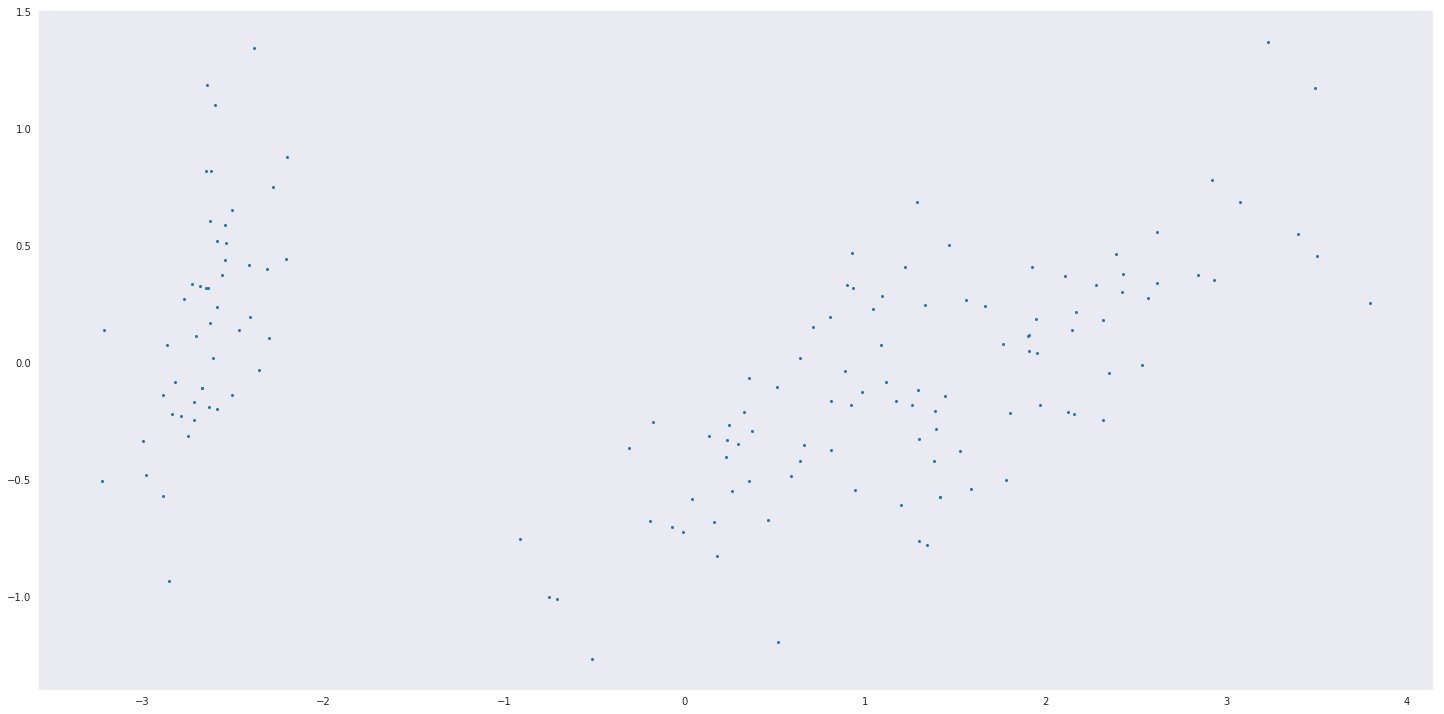

In [84]:
import matplotlib.pyplot as plt
plt.scatter(X.as_gpu_matrix()[:,0], X.as_gpu_matrix()[:,1], s = 4)

In [85]:
from cuml import DBSCAN

In [86]:
import numpy as np
import pandas as pd
import cudf
import numba
from librmm_cffi import librmm as rmm
from numba.cuda.cudadrv.driver import driver
import math
from numba import cuda

def row_matrix(df):
    # matrix = rmm.device_array(shape=(nrow, ncol), dtype=dtype, order='C')
    # for colidx, col in enumerate(cols):
    #     gpu_row_matrix.forall(matrix[:, colidx].size)(matrix[:, colidx],
    #                                                   col.to_gpu_array(),
    #                                                   nrow, ncol)
    """Compute the C (row major) version gpu matrix of df

    This implements the algorithm documented in
    http://devblogs.nvidia.com/parallelforall/efficient-matrix-transpose-cuda-cc/

    :param a: an `np.ndarray` or a `DeviceNDArrayBase` subclass. If already on
        the device its stream will be used to perform the transpose (and to copy
        `b` to the device if necessary).

    Adapted from numba:
    https://github.com/numba/numba/blob/master/numba/cuda/kernels/transpose.py
    """

    print("STARTING")

    cols = [df._cols[k] for k in df._cols]
    ncol = len(cols)
    nrow = len(df)
    dtype = cols[0].dtype

    a = df.as_gpu_matrix(order='F')
    b = rmm.device_array((nrow, ncol), dtype=dtype, order='C')
    dtype = numba.typeof(a)

    tpb = driver.get_device().MAX_THREADS_PER_BLOCK

    tile_width = int(math.pow(2, math.log(tpb, 2) / 2))
    tile_height = int(tpb / tile_width)

    tile_shape = (tile_height, tile_width + 1)

    @cuda.jit
    def kernel(input, output):

        tile = cuda.shared.array(shape=tile_shape, dtype=numba.float32)

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y
        bx = cuda.blockIdx.x * cuda.blockDim.x
        by = cuda.blockIdx.y * cuda.blockDim.y
        y = by + tx
        x = bx + ty

        if by + ty < input.shape[0] and bx + tx < input.shape[1]:
            tile[ty, tx] = input[by + ty, bx + tx]
        cuda.syncthreads()
        if y < output.shape[0] and x < output.shape[1]:
            output[y, x] = tile[tx, ty]

    # one block per tile, plus one for remainders
    blocks = int(b.shape[1] / tile_height + 1), int(b.shape[0] / tile_width + 1)
    # one thread per tile element
    threads = tile_height, tile_width
    kernel[blocks, threads](a, b)

    print("ANSWER: " + str(b.device_ctypes_pointer))

    return b


In [87]:
dbscan = DBSCAN(eps = 0.22, min_samples = 5)

In [88]:
dbscan.fit(X, row_matrix)

STARTING
ANSWER: c_ulong(140655657506304)
n_rows: 150
0x7fecf2606a00


In [89]:
set(dbscan.labels_)

{-1, 0, 1, 2}

In [90]:
type(X)

cudf.dataframe.dataframe.DataFrame

In [91]:
full_pca = PCA(n_components=df.shape[1])
full_pca.fit(df)

In [93]:
print("Explained variance %'s': " + str(full_pca.explained_variance_ratio_))

# Let's say we want to go down to two components. 
first_two_perc = sum(full_pca.explained_variance_ratio_[0:2])
print("Explained variance %'s of first two components: " + str(first_two_perc))

Explained variance %'s':              
0  0.92461634
1  0.05301554
2 0.017185122
3 0.005183111
Explained variance %'s of first two components: 0.9776318781077862


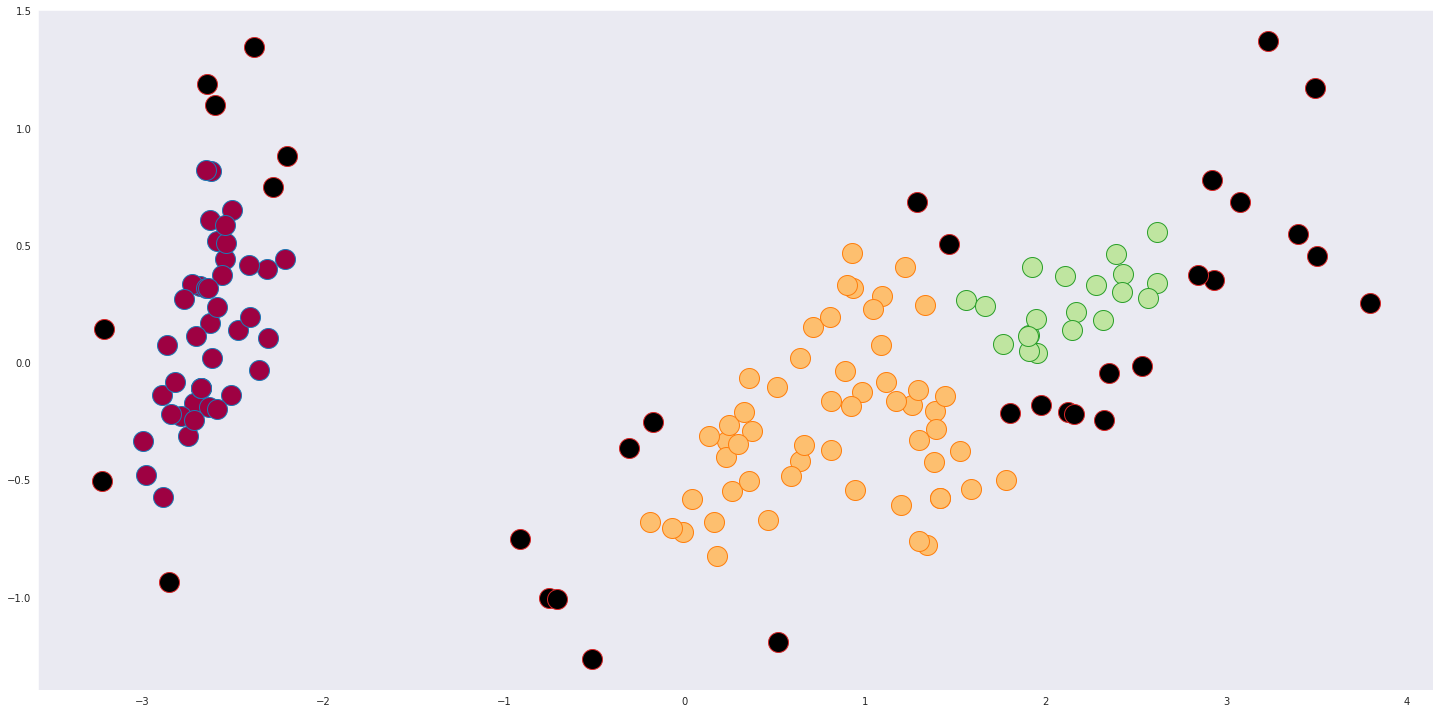

In [76]:
import matplotlib.pyplot as plt

db = dbscan

# Black removed and is used for noise instead.
l = db.labels_
unique_labels = set(l)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    c = X[l==k].as_gpu_matrix()


    plt.plot(c[:,0], c[:,1], '.', markerfacecolor=tuple(col), markersize = 40)

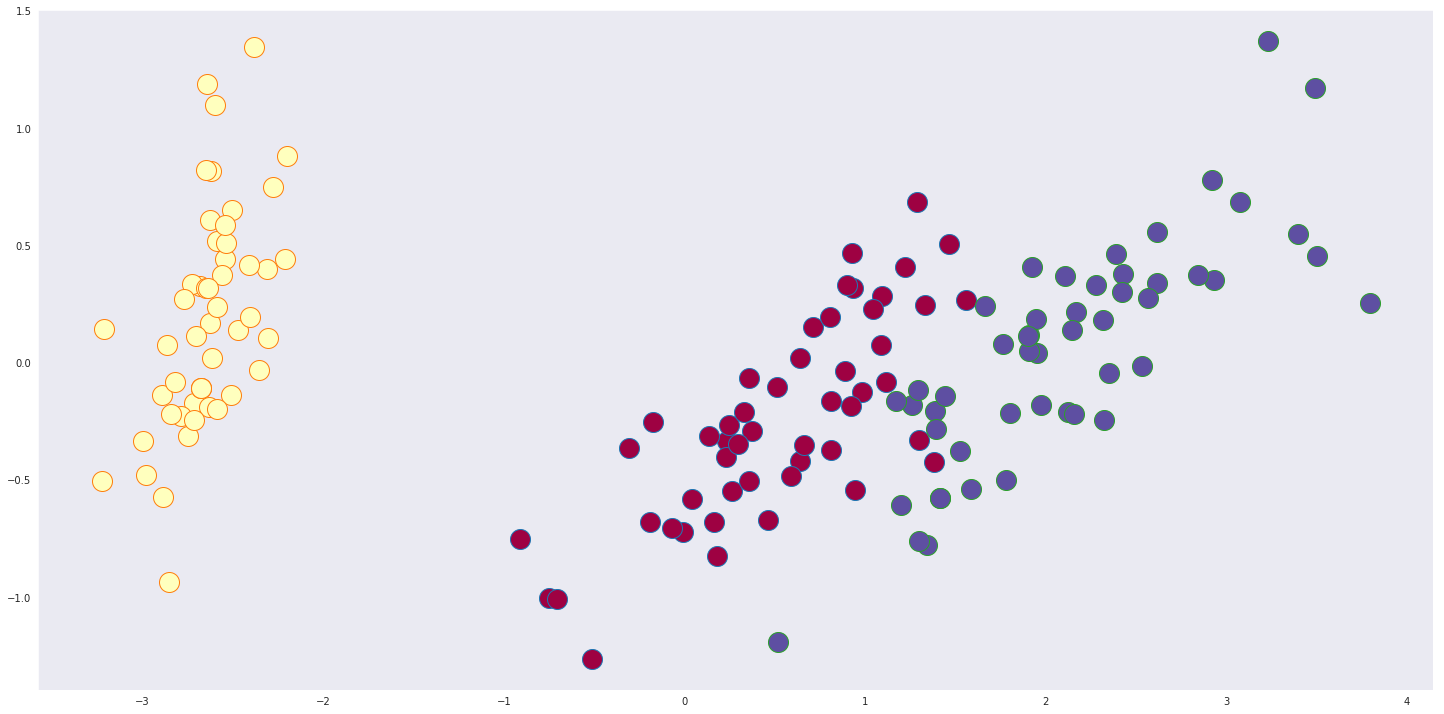

In [74]:
import matplotlib.pyplot as plt

db = dbscan

l = actual_labels.values

# Black removed and is used for noise instead.
unique_labels = set(actual_labels.values)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = l == k
    c = X[class_member_mask].as_gpu_matrix()

    plt.plot(c[:,0], c[:,1], '.', markerfacecolor=tuple(col), markersize=40)